In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

from probeinterface import generate_multi_columns_probe

import src.cellactivityrecodingsimulator as cars
from src.cellactivityrecodingsimulator.GroundTruthUnitsObject import GTUnitsObject

/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

In [3]:
from cellactivityrecodingsimulator.Settings import default_settings
from cellactivityrecodingsimulator.Settings import Settings
settings = Settings.from_dict(default_settings()).to_dict()

(<matplotlib.collections.PolyCollection at 0x11cfa3550>,
 <matplotlib.collections.PolyCollection at 0x11cfa3190>)

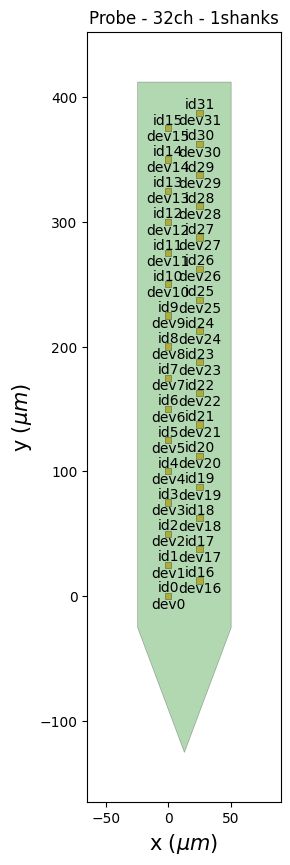

In [4]:
probe = generate_multi_columns_probe(
    num_columns=2,
    num_contact_per_column=16,
    xpitch=25,
    ypitch=25,
    y_shift_per_column=[0, 12.5],
    contact_shapes="square",
    contact_shape_params={"width": 5},
        # contact_shape_params : dict, default: {'radius': 6}
        # Parameters for the shape.
        # For circle: {"radius": float}
        # For square: {"width": float}
        # For rectangle: {"width": float, "height": float}
)
device_ids = list(range(probe.get_contact_count()))
probe.set_device_channel_indices(device_ids)

probe
from probeinterface.plotting import plot_probe
fig, ax = plt.subplots(figsize=(10, 10))
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

In [5]:
gtunit = GTUnitsObject.generate(
    settings=settings,
    num_column=2, 
    num_unit_per_column=16,
    xpitch=25,
    ypitch=25,
    y_shift_per_column=[0, 12.5],
    x_shift=10,
    id_major_order="row"
)
gtunit

GTUnits - 32 units

In [6]:
# from src.cellactivityrecodingsimulator.main import run
# dir_path = Path("./")
# carsobj = run(
#     dir=dir_path,
#     settings=settings,
#     units=gtunit,
#     probe=probe
# )
# carsobj
# carsobj.save_npz(dir_path / "default" / "carsobj.npz")

In [7]:
from pathlib import Path
from cellactivityrecodingsimulator.CarsObject import CarsObject
dir_path = Path("./")
carsobj2 = CarsObject.load_npz(file_path=Path(dir_path / "default" / "carsobj.npz"))

CarsObject loaded from default/carsobj.npz


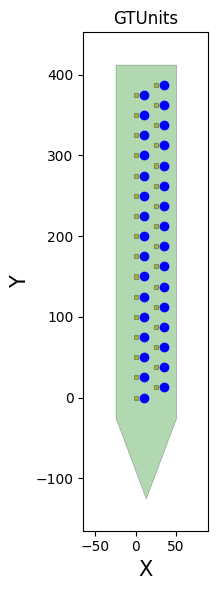

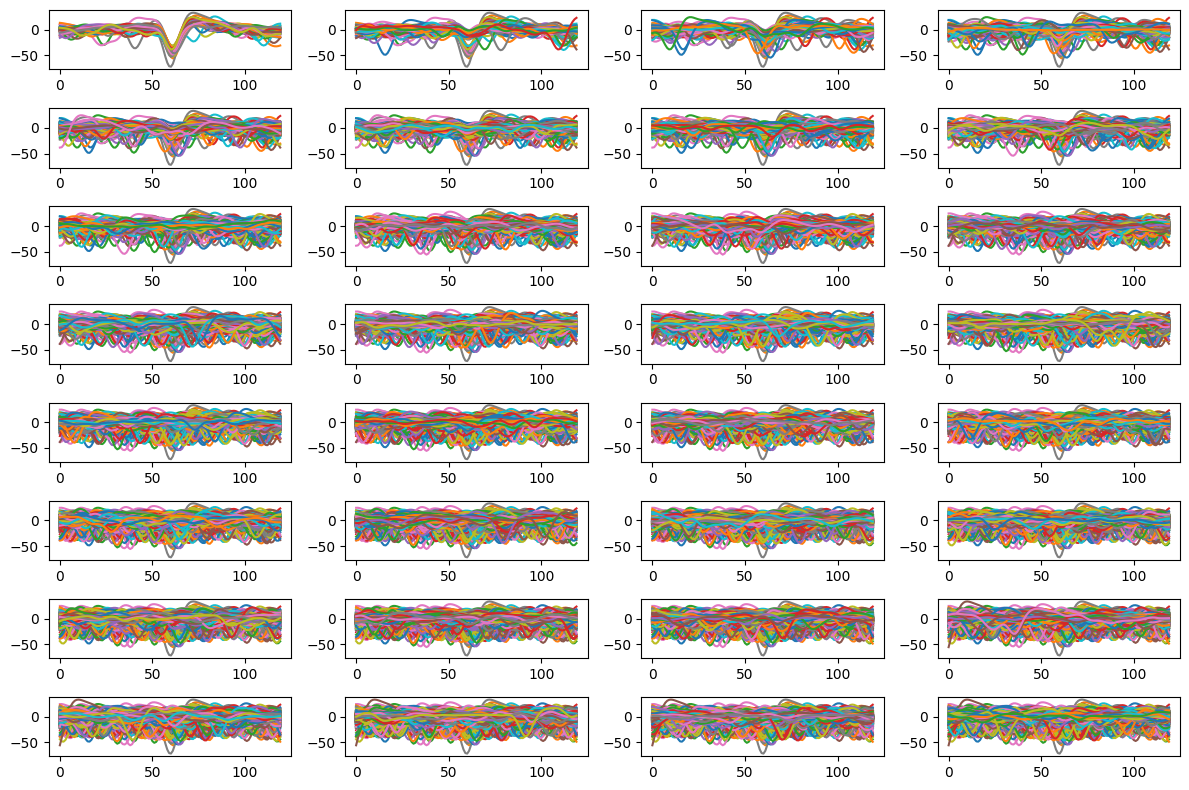

(<Figure size 1200x800 with 32 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

In [8]:
from src.cellactivityrecodingsimulator.plot import plot_GTUnits, plot_Signals, plot_Contacts, plot_Spikes

plot_GTUnits(gtunit, with_probe=True, probe=probe)
contacts = carsobj2.get_contacts()
plot_Spikes(contacts[0:1], gtunit)
# plot_Contacts(contacts, with_id=True)
# plot_Signals(contacts[0:1], signal_type="spike", time=[0, 0.1] ,fs=30000, is_title=False, is_xlabel=False,is_ylabel=False)

In [ ]:

recording = carsobj2.get_NumpyRecording([0])
# print(recording.get_probes())
recording = recording.set_probe(probe)
recording


NumpyRecording: 32 channels - 30.0kHz - 1 segments - 300,000 samples - 10.00s - int16 dtype 
                18.31 MiB

In [ ]:
print("available sorters", ss.available_sorters())
# mountainsort4/5 はwindows非対応．
print("Installed sorters", ss.installed_sorters())

available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'kilosort4', 'mountainsort4', 'mountainsort5', 'pykilosort', 'rtsort', 'simple', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['kilosort4', 'simple', 'spykingcircus2', 'tridesclous2']


In [ ]:
import psutil
import shutil
import os
import time
from pathlib import Path
from spikeinterface.sorters import run_sorter

def find_and_kill_locker(file_path):
    """
    指定されたファイルをロックしているプロセスを特定し、強制終了する関数。
    psutilライブラリを使用します。
    """
    target_path = Path(file_path).resolve()
    print(f"Searching for process locking: {target_path}")

    # すべての実行中プロセスを反復処理
    for proc in psutil.process_iter(['pid', 'name', 'open_files']):
        try:
            # プロセスが開いているファイルを確認
            if proc.info['open_files']:
                for item in proc.info['open_files']:
                    if Path(item.path).resolve() == target_path:
                        print(f"Found locking process: PID={proc.pid}, Name={proc.name}")
                        # 強制終了
                        proc.kill()
                        print(f"Process PID={proc.pid} has been terminated.")
                        return True
        except (psutil.NoSuchProcess, psutil.AccessDenied, FileNotFoundError):
            continue
    print("No process found locking the file.")
    return False

def save_with_cleanup(recording, folder, overwrite, n_jobs, total_memory):
    """
    ファイルロックエラー発生時に、ロックしているプロセスを終了させてから
    `recording.save()`を再試行するラッパー関数。
    """
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # save()を実行
            return recording.save(folder=folder, overwrite=overwrite, n_jobs=n_jobs, total_memory=total_memory)
        except PermissionError as e:
            if attempt < max_retries - 1:
                print(f"PermissionError caught: {e}. Retrying after cleanup...")
                # ロックしているプロセスを特定して終了を試みる
                if find_and_kill_locker(folder):
                    # プロセス終了後、少し待機して再試行
                    time.sleep(1)
                    continue
                else:
                    # ロッカーが見つからない場合は、手動でディレクトリ削除を試みる
                    try:
                        shutil.rmtree(folder)
                        print("Directory manually removed. Retrying save.")
                        time.sleep(1)
                        continue
                    except PermissionError as manual_e:
                        print(f"Manual removal failed: {manual_e}. The problem persists.")
                        raise manual_e
            else:
                print("Max retries reached. Failing to save.")
                raise e

def run_sorter_with_cleanup(sorter_name, recording, folder, **kwargs):
    """
    SpikeInterfaceのsorterを実行し、PermissionErrorが発生した場合は自己修復を試みる。
    """
    output_folder = Path(folder) / f"{sorter_name}_output"
    max_retries = 3
    retries = 0

    while retries < max_retries:
        try:
            print(f"Attempting to run sorter: {sorter_name}")
            sorting = run_sorter(sorter_name=sorter_name, recording=recording, folder=folder,
                                 remove_existing_folder=True, **kwargs)
            return sorting
        except PermissionError as e:
            print(f"PermissionError caught: {e}")
            if "The process cannot access the file" in str(e):
                print("File is locked. Attempting to find and kill the locking process.")
                if find_and_kill_locker(output_folder):
                    print("Locker terminated. Retrying sorter execution.")
                    retries += 1
                    continue
                else:
                    print("Failed to identify and terminate a locking process. Attempting manual removal.")
                    try:
                        shutil.rmtree(output_folder)
                        print("Directory successfully removed. Retrying sorter execution.")
                        retries += 1
                        continue
                    except PermissionError:
                        print("Manual removal failed. The problem persists.")
                        break
            else:
                raise # Re-raise if it's not the specific file lock error.

    raise RuntimeError("Failed to run sorter after multiple retries due to persistent file lock issues.")

In [ ]:
sorters = ["dartsort","kilosort4", "spykingcircus2"]


In [ ]:
# preprocess and run sort and make analyzer
sorting_list = []
analyzer_list = []
dir_name = "default"
for sorter in sorters:
    print("="*5, sorter, "="*5)
    try:
        if sorter == "kilosort4":
            
            pp_rec = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            pp_rec = spre.common_reference(pp_rec, reference="global")
            pp_rec = spre.whiten(pp_rec, int_scale=200)
            pp_rec = spre.correct_motion(pp_rec, preset="kilosort_like")
            pp_rec = pp_rec.save(folder=f"preprocessed_data_for_{sorter}_{dir_name}",overwrite=True, n_jobs=8, total_memory="2G")
            # pp_rec = save_with_cleanup(pp_rec, folder=f"preprocessed_data_for_{sorter}_{example_name}_{condition}", overwrite=True, n_jobs=8, total_memory="2G")
            recording_preprocessed = pp_rec
        else:
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
            recording_preprocessed = recording_cmr.save(format="binary", folder=f"preprocessed_data_for_{sorter}_{dir_name}", overwrite=True)
        
        sorting = ss.run_sorter(sorter_name=sorter, folder=f"{sorter}_{dir_name}" , remove_existing_folder=True, recording=recording_preprocessed)
        # sorting = run_sorter_with_cleanup(sorter_name=sorter, folder=f"{sorter}_{example_name}_{condition}" , remove_existing_folder=True, recording=recording_preprocessed)
        print(sorting)
        sorting_list.append(sorting)

        analyzer = si.create_sorting_analyzer(sorting=sorting, recording=recording_preprocessed, format='binary_folder', folder=f'analyzer_{sorter}_{dir_name}', overwrite=True)
        print(analyzer)
        analyzer_list.append(analyzer)
    except Exception as e:
        print(f"Error occurred: {e}")
        sorting_list.append(None)
        analyzer_list.append(None)
        continue
    finally:
        if 'pp_rec' in locals():
            del pp_rec
        if 'recording_preprocessed' in locals():
            del recording_preprocessed

===== dartsort =====
write_binary_recording 
engine=process - n_jobs=4 - samples_per_chunk=30,000 - chunk_memory=1.83 MiB - total_memory=7.32 MiB - chunk_duration=1.00s


/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/core/base.py:967: UserWarning: The extractor is not serializable to file. The provenance will not be saved.
  warnings.warn("The extractor is not serializable to file. The provenance will not be saved.")
write_binary_recording (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 19.81it/s]


Error occurred: 'dartsort'
===== kilosort4 =====


detect and localize (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 17.33it/s]


write_binary_recording 
engine=process - n_jobs=8 - samples_per_chunk=1,953,125 - chunk_memory=238.42 MiB - total_memory=1.86 GiB - chunk_duration=65.10s (1.09 minutes)


/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/sortingcomponents/motion/motion_utils.py:82: UserWarning: You are trying to estimate motion with `non-rigid` on a probe that is too short!get_spatial_windows(): win_step_um=200.0/win_scale_um=400.0/win_margin_um=-200.0 are too large for the probe size (depth range=387.5). Switching to rigid motion.
  warnings.warn(
/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/core/base.py:967: UserWarning: The extractor is not serializable to file. The provenance will not be saved.
  warnings.warn("The extractor is not serializable to file. The provenance will not be saved.")
write_binary_recording (workers: 1 processes): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Computing preprocessing variables.
INFO:kilosort.run_kilosort:----------------------------------------
INFO:kilosort.run_kil

KiloSortSortingExtractor: 16 units - 1 segments - 30.0kHz


estimate_sparsity (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 32.58it/s]

SortingAnalyzer: 32 channels - 16 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions
===== spykingcircus2 =====
write_binary_recording 
engine=process - n_jobs=4 - samples_per_chunk=30,000 - chunk_memory=1.83 MiB - total_memory=7.32 MiB - chunk_duration=1.00s



/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")
/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/core/base.py:967: UserWarning: The extractor is not serializable to file. The provenance will not be saved.
  warnings.warn("The extractor is not serializable to file. The provenance will not be saved.")
write_binary_recording (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 14.01it/s]


Error occurred: Spike sorting error trace:
Traceback (most recent call last):
  File "/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/sorters/basesorter.py", line 270, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/sorters/internal/spyking_circus2.py", line 325, in _run_from_folder
    outputs = find_cluster_from_peaks(
  File "/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/sortingcomponents/clustering/main.py", line 46, in find_cluster_from_peaks
    outputs = method_class.main_function(recording, peaks, params, job_kwargs=job_kwargs)
  File "/Users/rei/pyprojects/CellActivityRecordingSimulator/.venv/lib/python3.10/site-packages/spikeinterface/sortingcomponents/clustering/circus.py", line 85, in main_function
    rai

In [ ]:
extensions_to_compute = [
    "random_spikes",
    "waveforms",
    "noise_levels",
    "templates",
    "spike_amplitudes",
    "unit_locations",
    "spike_locations",
    "correlograms",
    "template_similarity"
]

extension_params = {
    "unit_locations": {"method": "center_of_mass"},
    "spike_locations": {"ms_before": 0.1},
    "correlograms": {"bin_ms": 0.1},
    "template_similarity": {"method": "cosine_similarity"}
}
try:
    if len(analyzer_list) == 0:
        for sorter in sorters:
            try:
                analyzer = si.load_sorting_analyzer(folder=f'analyzer_{sorter}_{dir_name}')
                print("="*5, sorter, "="*5)
                possible_extensions = analyzer.get_computable_extensions()
                print(possible_extensions)
                print(analyzer.has_recording())
            except Exception as e:
                print(f"Error loading analyzer: {e}")
                continue
    else:
        for index, analyzer in enumerate(analyzer_list):
            try:
                print("="*5, sorters[index], "="*5)
                possible_extensions = analyzer.get_computable_extensions()
                print(possible_extensions)
                print(analyzer.has_recording())
                analyzer.compute(extensions_to_compute, extension_params=extension_params)
            except Exception as e:
                print(f"Error loading analyzer: {e}")
                continue
except NameError:
    print("No analyzer list found.")
    analyzer_list = []
    for sorter in sorters:
        try:
            analyzer = si.load_sorting_analyzer(folder=f'analyzer_{sorter}_{dir_name}')
            print("="*5, sorter, "="*5)
            possible_extensions = analyzer.get_computable_extensions()
            print(possible_extensions)
            print(analyzer.has_recording())
        except Exception as e:
            print(f"Error loading analyzer: {e}")
            continue

===== dartsort =====
Error loading analyzer: 'NoneType' object has no attribute 'get_computable_extensions'
===== kilosort4 =====
['random_spikes', 'waveforms', 'templates', 'noise_levels', 'amplitude_scalings', 'correlograms', 'isi_histograms', 'principal_components', 'spike_amplitudes', 'spike_locations', 'template_metrics', 'template_similarity', 'unit_locations', 'quality_metrics']
True


noise_level (workers: 4 processes): 100%|██████████| 20/20 [00:00<00:00, 49.59it/s]
Compute : spike_amplitudes + spike_locations (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 534.93it/s]

===== spykingcircus2 =====
Error loading analyzer: 'NoneType' object has no attribute 'get_computable_extensions'


===== dartsort =====
Error plotting templates: 'NoneType' object has no attribute 'unit_ids'
===== kilosort4 =====
===== spykingcircus2 =====
Error plotting templates: 'NoneType' object has no attribute 'unit_ids'


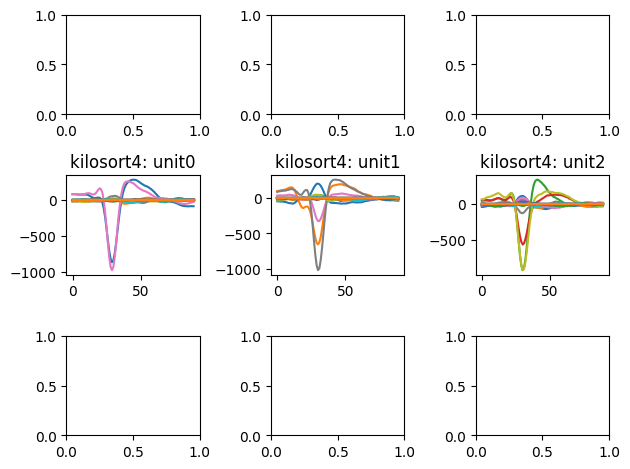

In [ ]:
n = len(analyzer_list)
n_unit = 3
fig, ax = plt.subplots(n,n_unit)
for analyzer_index, analyzer in enumerate(analyzer_list):
    try:
        print("="*5, sorters[analyzer_index], "="*5)
        for unit_index, unit_id in enumerate(analyzer.unit_ids[:n_unit]):
            template = analyzer.get_extension("templates").get_data(operator="average")[unit_index]
            ax[analyzer_index,unit_index].plot(template)
            ax[analyzer_index,unit_index].set_title(f"{sorters[analyzer_index]}: unit{unit_id}")
    except Exception as e:
        print(f"Error plotting templates: {e}")
        continue
fig.tight_layout()

In [ ]:
comp_gt_list = []
for sorting_index, sorting in enumerate(sorting_list):
    try:
        print("="*5, sorters[sorting_index], "="*5)
        comp_gt = sc.compare_sorter_to_ground_truth(
            gt_sorting=gtunit.to_Sorting(sampling_frequency=30000), 
            tested_sorting=sorting, 
            agreement_method="count",
            )
        comp_gt_list.append(comp_gt)
    except Exception as e:
        print(f"Error comparing sorter to ground truth: {e}")
        continue
# comp_pair = sc.compare_two_sorters(sorting1=sorting_KS4, sorting2=sorting_SC2)
# comp_multi = sc.compare_multiple_sorters(
#     sorting_list=[sorting_TDC, sorting_SC2, sorting_KS2], name_list=["tdc", "sc2", "ks2"]
# )

===== dartsort =====
Error comparing sorter to ground truth: 'NoneType' object has no attribute 'get_num_segments'
===== kilosort4 =====
===== spykingcircus2 =====
Error comparing sorter to ground truth: 'NoneType' object has no attribute 'get_num_segments'


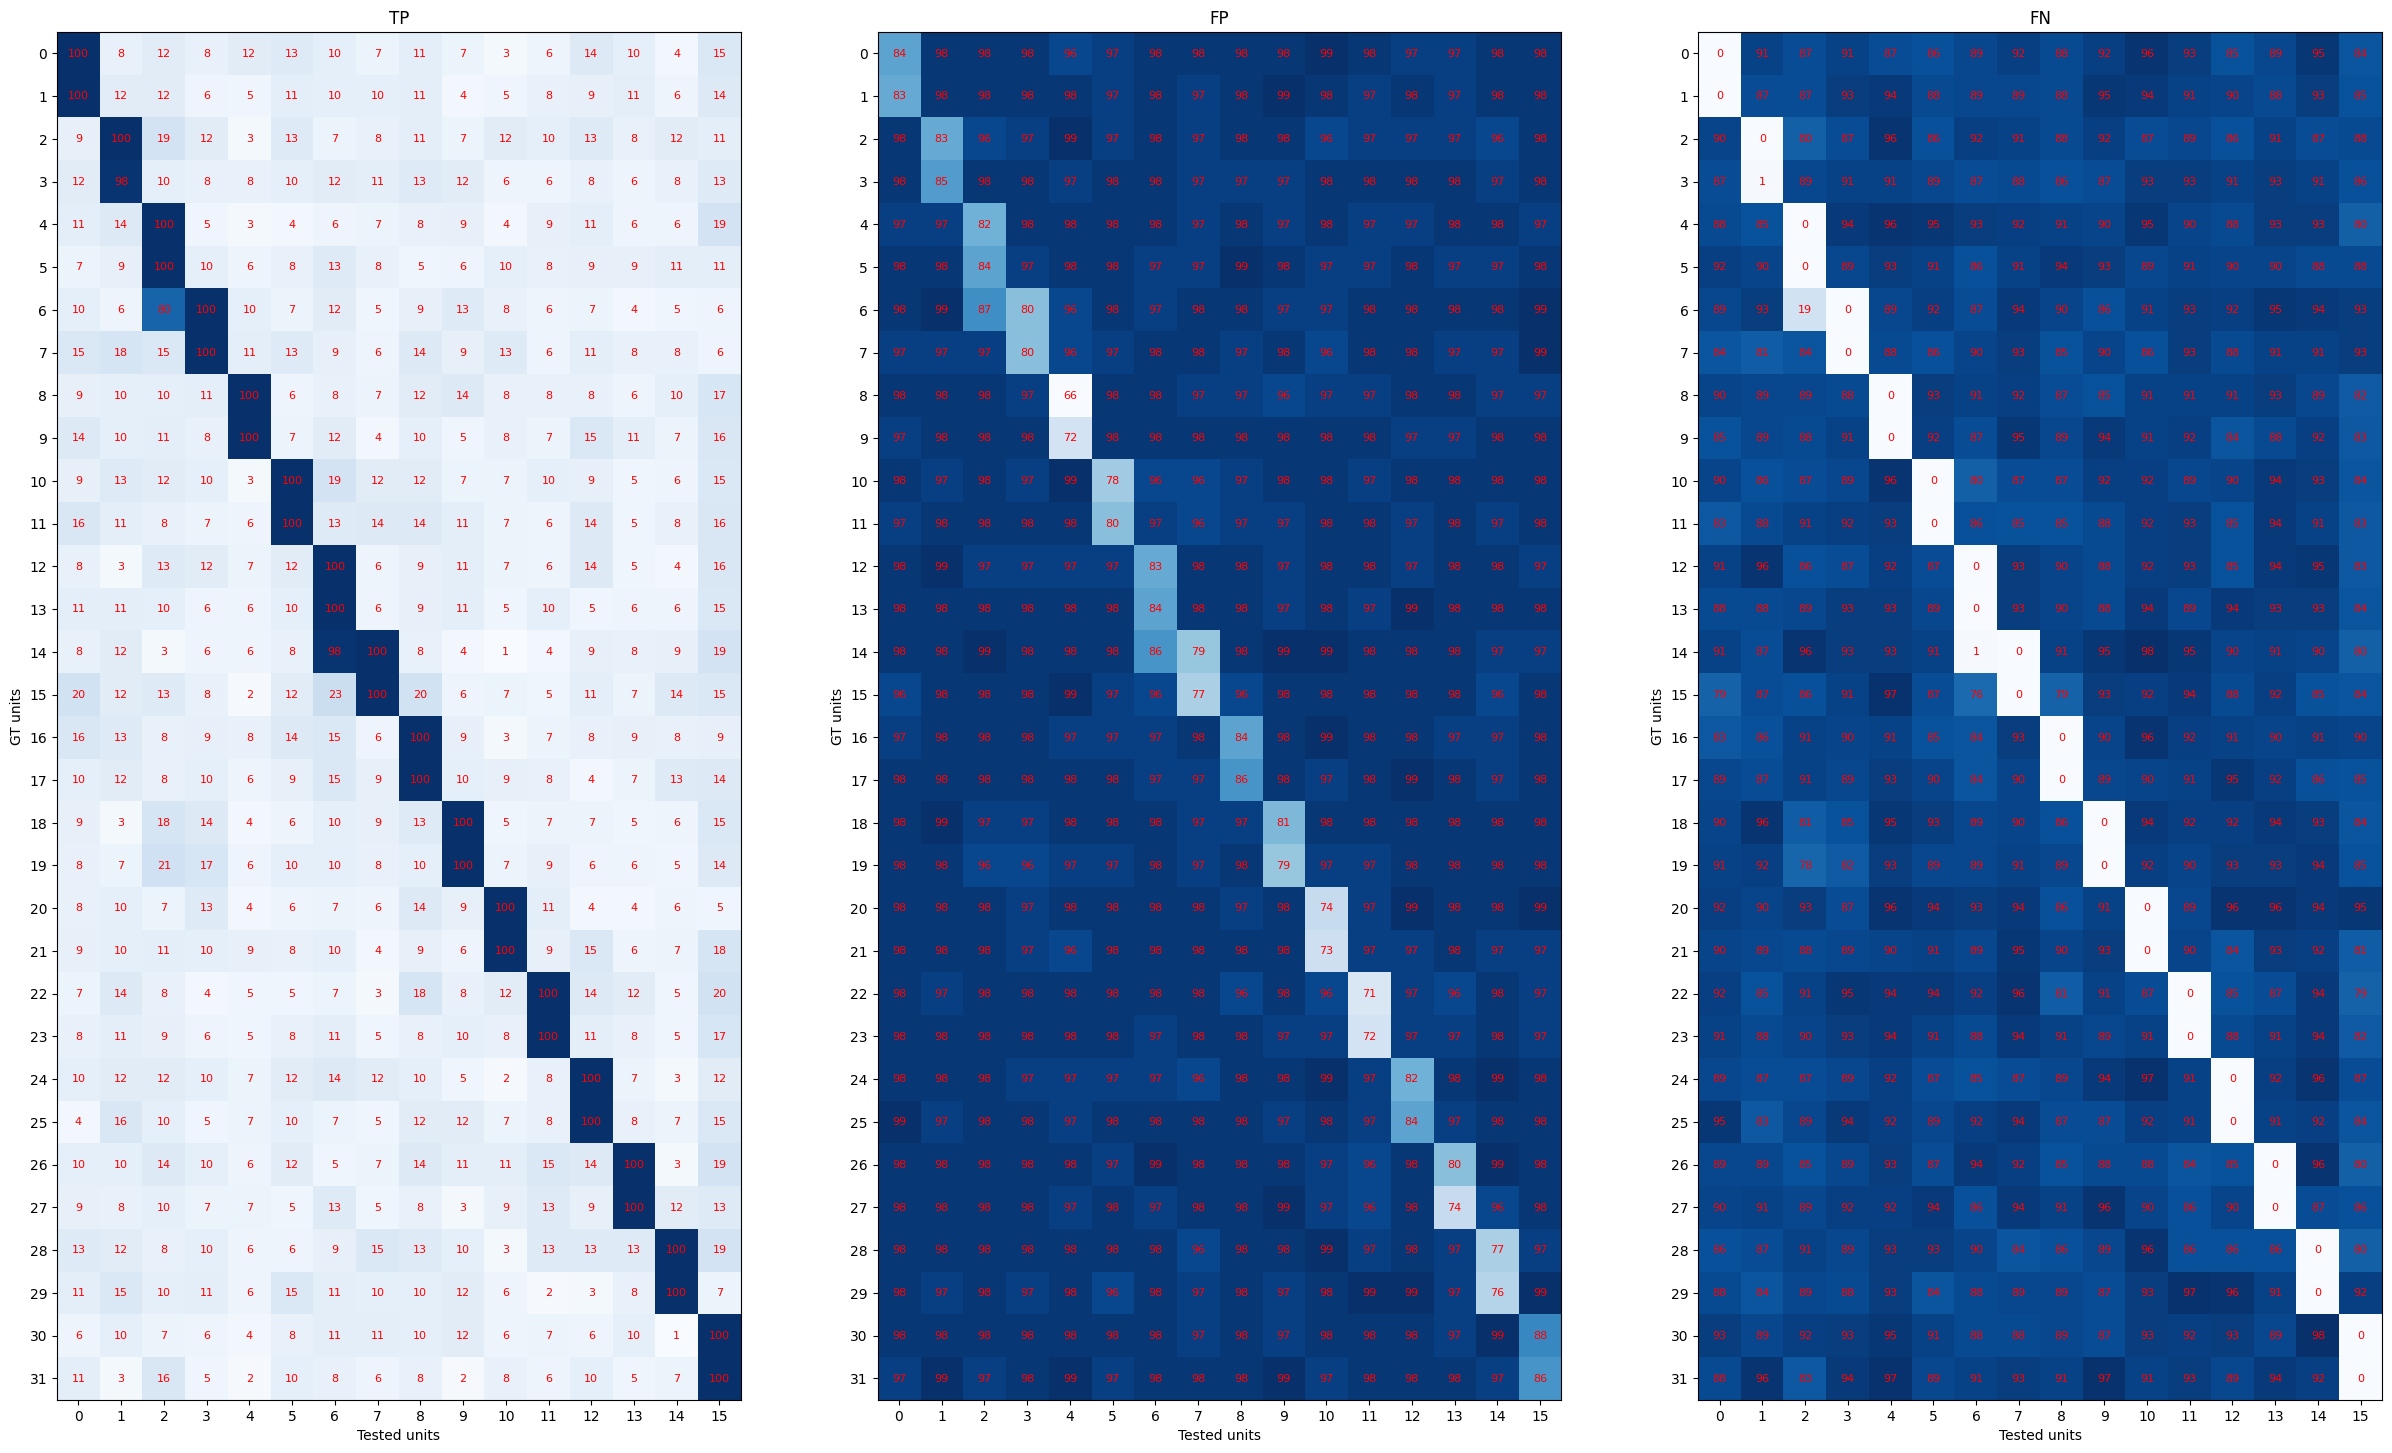

In [ ]:
import numpy as np
from typing import List

def compare_spike_times(gt_sorting, tested_sorting, delta_time_ms: float, fs: float, mode: str = "rate") -> np.ndarray:
    """
    Compares two lists of spike times and builds a simple agreement matrix.
    This function allows for one-to-many matching.

    Args:
        gt_sorting: The Ground Truth sorting object.
        tested_sorting: The tested sorting object.
        delta_time_ms (float): The time tolerance for matching, in milliseconds.
        fs (float): The sampling frequency in Hz.
        mode (str): The mode to calculate matrix. "rate" or "count".
    Returns:
        np.ndarray: An agreement matrix where rows correspond to GT units and columns correspond to tested units. The values are the number of matching spikes.
    """
    # Convert delta_time from ms to frames
    delta_time_frames = delta_time_ms * fs / 1000

    gt_unit_ids = gt_sorting.get_unit_ids()
    gt_spike_times = {unit_id: gt_sorting.get_unit_spike_train(unit_id) for unit_id in gt_unit_ids}
    tested_unit_ids = tested_sorting.get_unit_ids()
    tested_spike_times = {unit_id: tested_sorting.get_unit_spike_train(unit_id) for unit_id in tested_unit_ids}
    n_gt = len(gt_unit_ids)
    n_tested = len(tested_unit_ids)
    TP_matrix = np.zeros((n_gt, n_tested), dtype=int)
    FP_matrix = np.zeros((n_gt, n_tested), dtype=int)
    FN_matrix = np.zeros((n_gt, n_tested), dtype=int)

    # Correct iteration: Iterate through the individual spike time arrays
    for i, gt_id in enumerate(gt_unit_ids):
        gt_unit_spikes = gt_spike_times[gt_id]
        if gt_unit_spikes.size == 0:
            continue
        
        for j, tested_id in enumerate(tested_unit_ids):
            tested_unit_spikes = tested_spike_times[tested_id]
            if tested_unit_spikes.size == 0:
                continue

            matches = 0
            
            # The original code had a bug here.
            # It was iterating over a list of arrays, not a single array.
            
            # Correct logic: for each tested spike, find a match in the GT unit's array
            for gt_spike_time in gt_unit_spikes:
                # np.searchsorted must be used on a single, 1D array
                idx = np.searchsorted(tested_unit_spikes, gt_spike_time)
                
                found_match = False
                if idx < len(tested_unit_spikes) and np.abs(tested_unit_spikes[idx] - gt_spike_time) <= delta_time_frames:
                    found_match = True
                elif idx > 0 and np.abs(tested_unit_spikes[idx-1] - gt_spike_time) <= delta_time_frames:
                    found_match = True
                
                if found_match:
                    matches += 1
                    
            TP_matrix[i, j] = matches if mode == "count" else matches / len(gt_unit_spikes) * 100
            FP_matrix[i, j] = len(tested_unit_spikes) - matches if mode == "count" else ((len(tested_unit_spikes) - matches) / len(tested_unit_spikes) * 100)
            FN_matrix[i, j] = len(gt_unit_spikes) - matches if mode == "count" else ((len(gt_unit_spikes) - matches) / len(gt_unit_spikes) * 100)
            
    return TP_matrix, FP_matrix, FN_matrix

def plot_matrix(matrix, title, gt_unit_num, tested_unit_num, ax):
    im = ax.imshow(matrix, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Tested units")
    ax.set_ylabel("GT units")
    ax.set_xticks(range(tested_unit_num))
    ax.set_yticks(range(gt_unit_num))
    
    # 各セルに値を書き込む
    for i in range(gt_unit_num):
        for j in range(tested_unit_num):
            text = ax.text(j, i, f'{matrix[i, j]}',
                         ha="center", va="center", color="red", fontsize=8)

    # Example usage
# You need to specify a sampling frequency (fs) and a jitter threshold (delta_time_ms)
sampling_frequency = 30000.0  # Hz
time_threshold_ms = 1.0      # milliseconds
gt_sorting = gtunit.to_Sorting(sampling_frequency=30000)
# Calculate the agreement matrix
for i, sorting in enumerate(sorting_list):
    if sorting is not None:
        TP_matrix, FP_matrix, FN_matrix = compare_spike_times(
            gt_sorting=gt_sorting,
            tested_sorting=sorting,
            delta_time_ms=time_threshold_ms,
            fs=sampling_frequency,
            mode="rate"
        )

        if len(gt_sorting.get_unit_ids()) > len(sorting_list[i].get_unit_ids()):
            fig, ax = plt.subplots(1, 3, figsize=(30,24))
        else:
            fig, ax = plt.subplots(3, 1, figsize=(24,30))
        plot_matrix(TP_matrix, "TP", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[0])
        plot_matrix(FP_matrix, "FP", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[1])
        plot_matrix(FN_matrix, "FN", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[2])
        # fig.tight_layout()
    else:
        continue


===== kilosort4 =====
single: []
multi: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


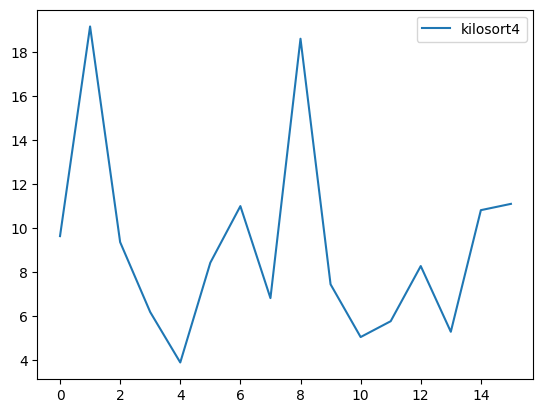

In [ ]:
def get_isi(spike_times):
    isi = np.diff(spike_times)
    return isi

def get_isi_violation_rate(spike_times, threshold_ms=2.0, sampling_frequency=30000.0):
    isi = get_isi(spike_times)
    isi_violation = np.sum(isi < threshold_ms * sampling_frequency / 1000) / len(isi) * 100
    return isi_violation

def get_isi_violation_rate_by_unit(sorting, threshold_ms=2.0, sampling_frequency=30000.0, dtype="dict"):
    isi_violation = {}
    for unit_id in sorting.get_unit_ids():
        isi_violation[unit_id] = get_isi_violation_rate(sorting.get_unit_spike_train(unit_id), threshold_ms, sampling_frequency)
    if dtype == "dict":
        return isi_violation
    elif dtype == "list":
        return list(isi_violation.values())
    else:
        ValueError("dtype must be 'dict' or 'list'")

def get_single_multi_unit(sorting, threshold_rate=50, threshold_ms=2.0, sampling_frequency=30000.0, unit_type="both"):
    single_unit = []
    multi_unit = []
    isi_violation = get_isi_violation_rate_by_unit(sorting, threshold_ms, sampling_frequency)
    unit_ids = sorting.get_unit_ids()
    for i, unit_id in enumerate(unit_ids):
        if isi_violation[unit_id] > threshold_rate:
            multi_unit.append(int(unit_id))
        else:
            single_unit.append(int(unit_id))

    try:    
        if unit_type == "single":
            return single_unit
        elif unit_type == "multi":
            return multi_unit
        elif unit_type == "both":
            return single_unit, multi_unit
    except:
        ValueError("unit_type must be 'single', 'multi', or 'both'")
    
        

sampling_frequency = 30000.0  # Hz
time_threshold_ms = 1.0      # milliseconds
mua_threshold_rate = 0.2
for i, sorting in enumerate(sorting_list):
    if sorting is not None:
        isi_violation_dict = get_isi_violation_rate_by_unit(sorting)
        isi_violation_values = list(isi_violation_dict.values())
        plt.plot(isi_violation_values, label=sorters[i])
        single_unit, multi_unit = get_single_multi_unit(sorting, threshold_rate=mua_threshold_rate, unit_type="both")
        print("="*5, f"{sorters[i]}", "="*5)
        print(f"single: {single_unit}")
        print(f"multi: {multi_unit}")
    else:
        continue
plt.legend()


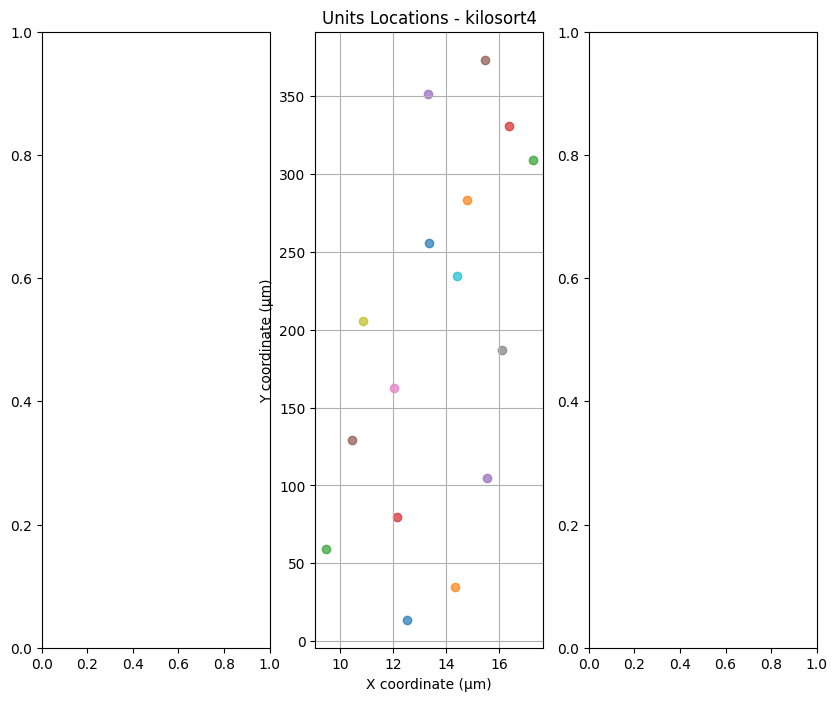

In [ ]:
fig, ax = plt.subplots(1, len(analyzer_list), figsize=(10, 8))
for index, analyzer in enumerate(analyzer_list):
    if analyzer is not None:
        unit_locations = analyzer.get_extension("unit_locations").get_data()
        [ax[index].scatter(unit_location[0], unit_location[1], alpha=0.7) for unit_location in unit_locations]
        ax[index].set_title(f"Units Locations - {sorters[index]}")
        ax[index].set_xlabel("X coordinate (μm)")
        ax[index].set_ylabel("Y coordinate (μm)")
        ax[index].grid(True)
    else:
        continue
plt.show()
    

(16, 90, 32)


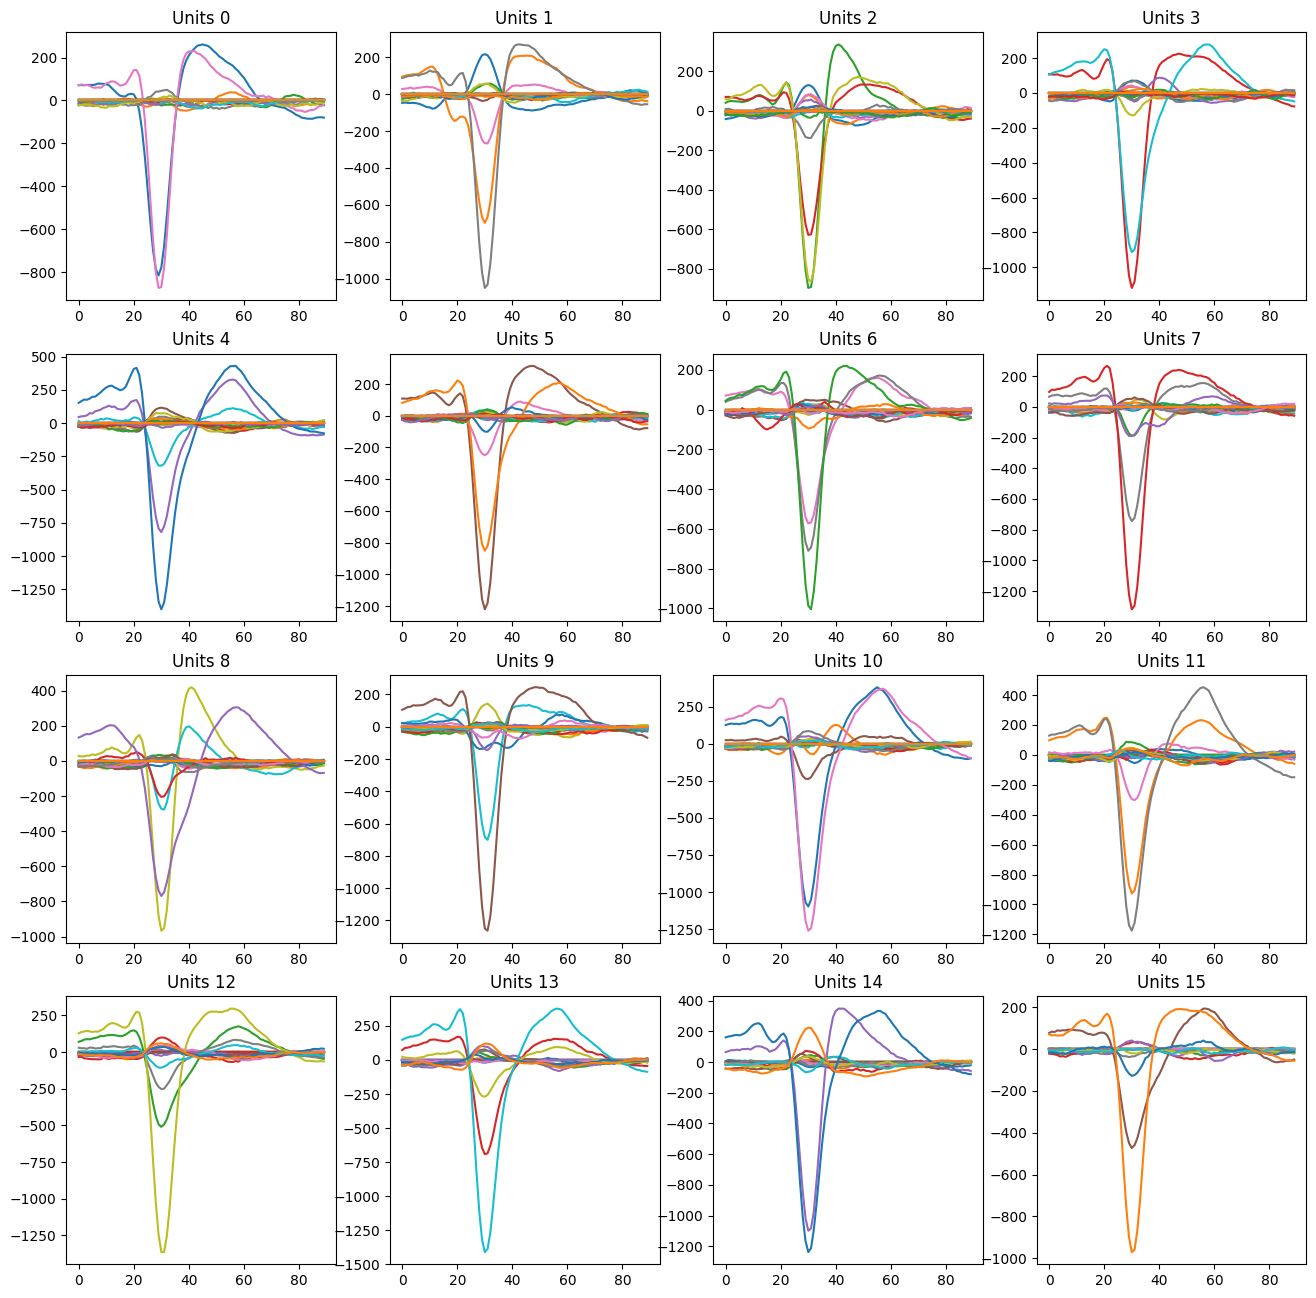

In [ ]:
for i, analyzer in enumerate(analyzer_list):
    if analyzer is not None:
        templates = analyzer.get_extension("templates").get_data()
        print(templates.shape)
        n_templates = len(templates)
        n_rows = (n_templates + 3) // 4  # 4列で行数を計算
        fig, axes = plt.subplots(n_rows, 4, figsize=(4*4, 4*n_rows))
        
        # axesを1次元配列に変換
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes_flat = axes.flatten()
        
        for j, template in enumerate(templates):
            if j < len(axes_flat):
                axes_flat[j].plot(template)
                axes_flat[j].set_title(f"Units {j}")
                # axes_flat[j].set_xlabel("Time (samples)")
                # axes_flat[j].set_ylabel("Amplitude")
        
        # 使用しないサブプロットを非表示
        for j in range(len(templates), len(axes_flat)):
            axes_flat[j].set_visible(False)
    else:
        continue
    
    # plt.tight_layout()
    plt.show()


In [ ]:
for i, analyzer in enumerate(analyzer_list):
    # analyzer.compute("quality_metrics")
    if analyzer is not None:
        quality_metrics = analyzer.get_extension("quality_metrics")
        # print(quality_metrics["isi_violations_ratio"].shape)
        plt.plot(quality_metrics["isi_violations_ratio"])
        plt.show()
    else:
        continue
    
    

TypeError: 'NoneType' object is not subscriptable

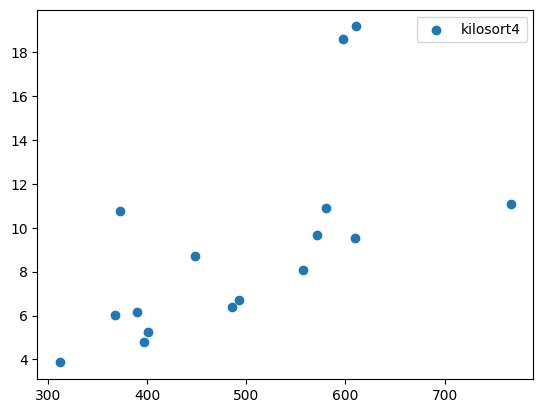

In [ ]:
def get_spike_num_by_unit(sorting, dtype="dict"):
    spike_num = {}
    for unit_id in sorting.get_unit_ids():
        spike_num[unit_id] = len(sorting.get_unit_spike_train(unit_id))
    if dtype == "dict":
        return spike_num
    elif dtype == "list":
        return list(spike_num.values())
    else:
        ValueError("dtype must be 'dict' or 'list'")

for i, sorting in enumerate(sorting_list):
    if sorting is not None:
        isi_violation_list = get_isi_violation_rate_by_unit(sorting, dtype="list")
        spike_num_list = get_spike_num_by_unit(sorting, dtype="list")
        plt.scatter(spike_num_list, isi_violation_list, label=sorters[i])
    else:
        continue
    plt.legend()
    plt.show()


In [ ]:
# for i, comp_gt in enumerate(comp_gt_list):
#     print("="*5, sorters[i], "="*5)
#     print(comp_gt.get_performance(method="by_unit"))
#     if len(gt_sorting.get_unit_ids()) > len(sorting_list[i].get_unit_ids()):
#         fig, ax = plt.subplots(1, 2, figsize=(10,8))
#     else:
#         fig, ax = plt.subplots(2, 1, figsize=(10,8))
        
#     # 混同行列
#     sw.plot_confusion_matrix(
#         comp_gt,
#         unit_ticks=True,
#         count_text=True,
#         ax=ax[0], 
#     )

#     # 合意行列
#     w_agr = sw.plot_agreement_matrix(
#         comp_gt, 
#         ordered=False, 
#         count_text=True, 
#         unit_ticks=False, 
#         ax=ax[1],
#     )
#     ax[0].set_title(f"{sorters[i]} confusion")
#     ax[1].set_title(f"{sorters[i]} agreement")
#     fig.tight_layout()

In [ ]:
# sw.plot_all_amplitudes_distributions(analyzer_list[0])
# sw.plot_amplitudes(analyzer_list[0])
# sw.plot_autocorrelograms(analyzer_list[0])
# # sw.plot_comparison_collision_by_similarity(
# #     comp_gt_list[0], 
# #     templates_array=np.load(dir_path / "spike_templates.npy", allow_pickle=True).T,
# #     )
# sw.plot_crosscorrelograms(analyzer_list[0])
# sw.plot_isi_distribution(analyzer_list[0])


In [ ]:
# sw.plot_multicomparison_agreement(comp_gt_list[0])
# sw.plot_multicomparison_agreement_by_sorter(comp_gt_list[0])
# sw.plot_multicomparison_graph(comp_gt_list[0])
# sw.plot_peak_activity(recording, analyzer_list[0].get_detect_peaks())
# sw.plot_probe_map(recording)
# # sw.plot_quality_metrics(analyzer_list[0])
# sw.plot_rasters(analyzer_list[0])

# sw.plot_sorting_summary(analyzer_list[0], backend="spikeinterface_gui")